In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

# Load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
df = pd.read_csv(url)

# Prepare the dataset
selected_columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]
df = df[selected_columns]

# Rename the target column for easier access
df = df.rename(columns={'fuel_efficiency_mpg': 'mpg'})

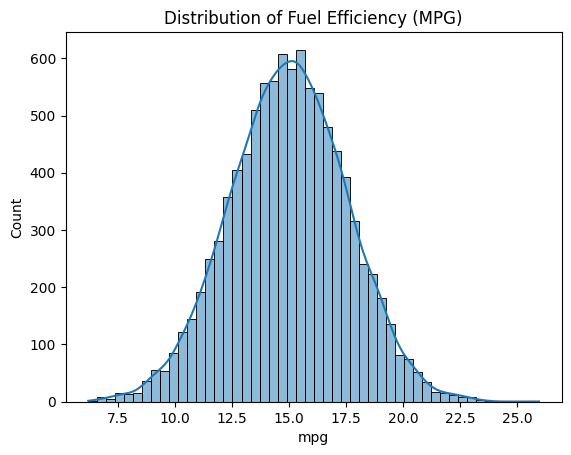

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df.mpg, bins=50, kde=True)
plt.title('Distribution of Fuel Efficiency (MPG)')
plt.show()

In [5]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
mpg                      0
dtype: int64


In [6]:
# Calculate the median of the 'horsepower' column
horsepower_median = df['horsepower'].median()
print(horsepower_median)

149.0


In [7]:
def split_data(df, seed):
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    return df_train, df_val, df_test

# Base features for our model
base_features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'mpg'

# Split the data with seed 42 for Q3 and Q4
df_train, df_val, df_test = split_data(df, seed=42)

In [8]:
def prepare_X(df, fill_value):
    df = df.copy()
    df['horsepower'] = df['horsepower'].fillna(fill_value)
    X = df[base_features].values
    return X

def train_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# --- Option 1: Fill with 0 ---
X_train_0 = prepare_X(df_train, fill_value=0)
y_train = df_train[target].values
model_0 = train_linear_regression(X_train_0, y_train)

X_val_0 = prepare_X(df_val, fill_value=0)
y_val = df_val[target].values
y_pred_0 = model_0.predict(X_val_0)

rmse_0 = rmse(y_val, y_pred_0)
print(f"RMSE with 0: {round(rmse_0, 2)}")

# --- Option 2: Fill with mean ---
horsepower_mean = df_train['horsepower'].mean()
X_train_mean = prepare_X(df_train, fill_value=horsepower_mean)
model_mean = train_linear_regression(X_train_mean, y_train)

X_val_mean = prepare_X(df_val, fill_value=horsepower_mean)
y_pred_mean = model_mean.predict(X_val_mean)

rmse_mean = rmse(y_val, y_pred_mean)
print(f"RMSE with mean: {round(rmse_mean, 2)}")

RMSE with 0: 0.52
RMSE with mean: 0.46


In [9]:
# We use the same data split (seed 42) and fill NAs with 0
X_train = prepare_X(df_train, fill_value=0)
X_val = prepare_X(df_val, fill_value=0)
y_train = df_train[target].values
y_val = df_val[target].values

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
best_score = float('inf')
best_r = None

for r in r_values:
    model = Ridge(alpha=r, solver='sag', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = rmse(y_val, y_pred)
    
    print(f"r={r}, RMSE={round(score, 2)}")
    
    if score < best_score:
        best_score = score
        best_r = r

print(f"\nThe best r is {best_r} with an RMSE of {round(best_score, 2)}")

r=0, RMSE=0.52
r=0.01, RMSE=0.52
r=0.1, RMSE=0.52
r=1, RMSE=0.52
r=5, RMSE=0.52
r=10, RMSE=0.52
r=100, RMSE=0.52

The best r is 0 with an RMSE of 0.52
